# **Read file**

In [2]:
# Import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import accuracy_score

In [3]:
#drive.mount('/content/drive')
file_path = '1305.csv'
df = pd.read_csv(file_path)
df.keys()

Index(['Volunteer number', 'Session (1, 2)',
       'Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)',
       'Timepoint relative to drug administration (in minutes)',
       '1. Overall Psilocybin Effect (0 = none to\n10 = strongest imaginable)',
       '2. Now-ness (0 = none to\n10 = strongest imaginable)  ',
       '3. Letting Go (0 = none to\n10 = strongest imaginable)',
       '4. Equanimity (0 = none to\n10 = strongest imaginable)',
       '5. Pure being and pure awareness (0 = none to\n10 = strongest imaginable)',
       '6. Fusion of your personal self into a larger whole (0 = none to\n10 = strongest imaginable)',
       '7. Sense of reverence or sacredness (0 = none to\n10 = strongest imaginable)',
       '8. Timelessness (0 = none to\n10 = strongest imaginable)',
       '9. Ineffability (0 = none to\n10 = strongest imaginable)',
       '10. Feelings of joy (0 = none to\n10 = strongest imaginable)',
       '11. Feelings of peace and tranquility (0 = none to\n10 = stronges

# **Preprocess**

In [4]:
# Remove the columns "Unnamed: 17" and "Unnamed: 18"
if 'Unnamed: 17' in df.columns:
  df = df.drop('Unnamed: 17', axis=1)
if 'Unnamed: 18' in df.columns:
  df = df.drop('Unnamed: 18', axis=1)

In [5]:
def remove_ms_feature(features, timepoints, vol_num, condition):
      # prompt: if a row of features contains 'ms', save that index and remove
      remove_idx = []
      for i in range(features.shape[0]):
        for j in range(features.shape[1]):
          if type(features[i,j]) == str and 'ms' in features[i,j]:
            remove_idx.append(i)

      features = np.delete(features, remove_idx, axis=0)
      timepoints = np.delete(timepoints, remove_idx, axis=0)
      vol_num = np.delete(vol_num, remove_idx, axis=0)
      condition = np.delete(condition, remove_idx, axis=0)
      timepoints[timepoints == 'baseline'] = -20

      return features, timepoints, vol_num, condition


def create_matrix():

      # read df from csv
      df = pd.read_csv(file_path)

      print(f"dataframe shape: ",df.shape)
      # interplot the ms datapoints
      # if interplot_or_delete == 'interplot':
      #    feature_names = [df.keys()[i] for i in range(4,17)]
      #    temp = interplotting(df, feature_names)
      #    df[feature_names]= temp



      # create feature matrix in np.array
      vol_num = df[df.keys()[0]]
      condition = df[df.keys()[2]]
      timepoints = df[df.keys()[3]]
      feat1 = df[df.keys()[4]]
      feat2 = df[df.keys()[5]]
      feat3 = df[df.keys()[6]]
      feat4 = df[df.keys()[7]]
      feat5 = df[df.keys()[8]]
      feat6 = df[df.keys()[9]]
      feat7 = df[df.keys()[10]]
      feat8 = df[df.keys()[11]]
      feat9 = df[df.keys()[12]]
      feat10 = df[df.keys()[13]]
      feat11 = df[df.keys()[14]]
      feat12 = df[df.keys()[15]]
      feat13 = df[df.keys()[16]]

      # Delete rows corresponds to average measurements
      idx = [i for i in range(len(timepoints)) if (timepoints[i] != 'Avg from capsule to 360')]

      vol_num = vol_num[idx]
      condition = condition[idx]
      timepoints = timepoints[idx]
      feat1 = feat1[idx]
      feat2 = feat2[idx]
      feat3 = feat3[idx]
      feat4 = feat4[idx]
      feat5 = feat5[idx]
      feat6 = feat6[idx]
      feat7 = feat7[idx]
      feat8 = feat8[idx]
      feat9 = feat9[idx]
      feat10 = feat10[idx]
      feat11 = feat11[idx]
      feat12 = feat12[idx]
      feat13 = feat13[idx]

      features = np.stack([feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8, feat9, feat10, feat11, feat12, feat13])
      features = features.T

      print(f"matrix shape before delete: ",features.shape)

      # if interplot_or_delete=='delete':
      features, timepoints, vol_num, condition = remove_ms_feature(features, timepoints, vol_num, condition)

      print(f"matrix shape after delete: ",features.shape)
      return features, timepoints, vol_num, condition

features, timepoints, vol_num, condition = create_matrix()
features.shape

dataframe shape:  (610, 19)
matrix shape before delete:  (549, 13)
matrix shape after delete:  (471, 13)


(471, 13)

In [6]:
# Convert elements in timepoints, vol_num, to int
timepoints = [int(tp) if isinstance(tp, str) and tp.isdigit() else tp for tp in timepoints]
vol_num = [int(vn) for vn in vol_num]

# Convert elements in features to int (if possible)
for i in range(features.shape[0]):
  for j in range(features.shape[1]):
    if isinstance(features[i, j], str) and features[i, j].isdigit():
      features[i, j] = int(features[i, j])

features.dtype

dtype('O')

In [8]:
questions = df.keys()[4:]
questions = [question.split('(')[0].strip() for question in questions]
questions

['1. Overall Psilocybin Effect',
 '2. Now-ness',
 '3. Letting Go',
 '4. Equanimity',
 '5. Pure being and pure awareness',
 '6. Fusion of your personal self into a larger whole',
 '7. Sense of reverence or sacredness',
 '8. Timelessness',
 '9. Ineffability',
 '10. Feelings of joy',
 '11. Feelings of peace and tranquility',
 '12. Positive Emotional Valence',
 '13. Negative emotional valence']

In [9]:
# Change elements in list 'condition'. PLA ->Placebo-A, PSIL -> Psilocybin-A, and EXP -> Psilocybin-B

condition = np.array([
    "Placebo-A" if x == "PLA" else
    "Psilocybin-A" if x == "PSIL" else
    "Psilocybin-B" if x == "EXP" else
    x for x in condition
])

timepoints = np.array(timepoints)

# **PCA Analysis**

## Reshape numpy arrays for pca

In [10]:
# features
timepoints_id = [i for i in range(len(timepoints)) if timepoints[i] == -20]
response_collection = []

# iterate over questions
for i in range(features.shape[1]):
    # extract question info
    response_delete = features[:,i]


    rows = []
    condition_reshaped = []
    vol_num_reshaped = []

    # iterate over feature_delete, delete individuals that has lower than 8 datapints
    for i in range(len(timepoints_id)-1):
        if timepoints_id[i+1] - timepoints_id[i] == 8:
            temp = response_delete[timepoints_id[i]:timepoints_id[i+1]]
            rows.append(temp)

            # keep track of condition after reshaped
            condition_reshaped.append(condition[timepoints_id[i]])
            vol_num_reshaped.append(vol_num[timepoints_id[i]])


    response_collection.append(np.array(rows))

# convert list to np arrays

feature_reshaped = np.array(response_collection)
condition_reshaped = np.array(condition_reshaped)


print(feature_reshaped.shape)
print(condition_reshaped.shape)


(13, 50, 8)
(50,)


In [11]:
vol_num_reshaped = np.array(vol_num_reshaped)
vol_num_reshaped

array([708, 709, 710, 710, 716, 722, 722, 727, 730, 730, 732, 732, 733,
       733, 738, 739, 740, 740, 742, 743, 744, 745, 745, 746, 746, 751,
       752, 752, 753, 754, 755, 758, 758, 761, 762, 763, 763, 765, 767,
       767, 768, 768, 769, 769, 771, 771, 772, 775, 775, 776])

## PCA results with same vol_number individuals connected

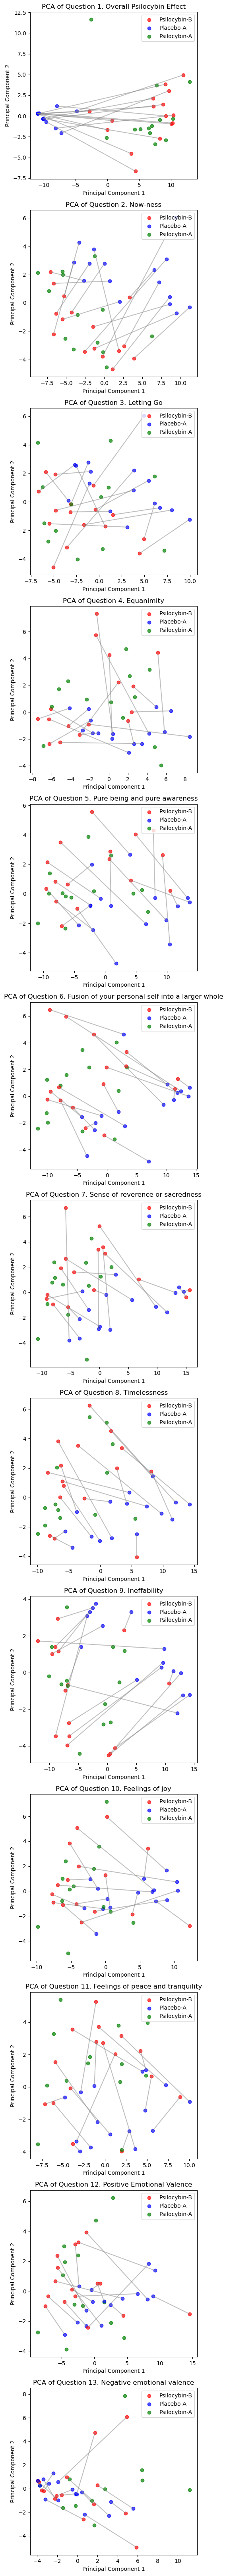

In [12]:
# Perform pca on features for each 13 questions.
# After performing pca, plot the spots, and connect the points that has the same vol_num value in vol_num_reshaped.
# Set legend to either 'EXP', 'PLA', or 'PSIL', do not display the vol_num in legend. And for each connected dots, one should be 'PLA', and the other should be 'EXP'.
# Distinguish them in color. Then, add the 'PSIL' to the plot, which should not be connected

# Define the palette for plotting
palette = {'Placebo-A': 'blue', 'Psilocybin-B': 'red', 'Psilocybin-A': 'green'}

# Create a figure with subplots
fig, axes = plt.subplots(13, 1, figsize=(8, 65))  # 13 rows, 1 column

# Loop through each question (feature)
for i in range(13):
    # Extract data for the current question
    data = feature_reshaped[i]

    # Perform PCA on features_interplot
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)

    # Plot for features_interplot (left side)
    unique_vol_nums = np.unique(vol_num_reshaped)
    for vol_num in unique_vol_nums:
        indices = np.where(vol_num_reshaped == vol_num)[0]
        if len(indices) > 0:
            # Find the condition for the first index of this vol_num
            condition_for_vol_num = condition_reshaped[indices]
            # Check if there are both 'EXP' and 'PLA' conditions for this vol_num
            if 'Psilocybin-B' in condition_for_vol_num and 'Placebo-A' in condition_for_vol_num:
                exp_indices = [idx for idx in indices if condition_reshaped[idx] == 'Psilocybin-B']
                pla_indices = [idx for idx in indices if condition_reshaped[idx] == 'Placebo-A']

                if exp_indices and pla_indices:
                    # Find the exp and pla indices for vol_num
                    exp_index = exp_indices[0]
                    pla_index = pla_indices[0]

                    # Plot the points
                    axes[i].scatter(pca_result[exp_index, 0], pca_result[exp_index, 1],
                                      c=palette['Psilocybin-B'], label='Psilocybin-B', alpha=0.7)
                    axes[i].scatter(pca_result[pla_index, 0], pca_result[pla_index, 1],
                                      c=palette['Placebo-A'], label='Placebo-A', alpha=0.7)

                    # Connect the points with a line
                    axes[i].plot([pca_result[exp_index, 0], pca_result[pla_index, 0]],
                                   [pca_result[exp_index, 1], pca_result[pla_index, 1]],
                                   color='gray', alpha=0.5)


            # Plot PSIL points without connecting
            psil_indices = [idx for idx in indices if condition_reshaped[idx] == 'Psilocybin-A']
            if psil_indices:
                axes[i].scatter(pca_result[psil_indices, 0], pca_result[psil_indices, 1],
                                  c=palette['Psilocybin-A'], label='Psilocybin-A', alpha=0.7)



    axes[i].set_title(f'PCA of Question {questions[i]}')
    axes[i].set_xlabel('Principal Component 1')
    axes[i].set_ylabel('Principal Component 2')
    axes[i].set_box_aspect(1)

    # Remove duplicate labels from legend
    handles, labels = axes[i].get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    axes[i].legend(unique_handles, unique_labels, loc='upper right')



# Adjust layout and show the figure
plt.tight_layout()
plt.show()

## Juxtapose PCA with k-means clustering

/Users/apple/opt/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/apple/opt/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/apple/opt/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/apple/opt/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

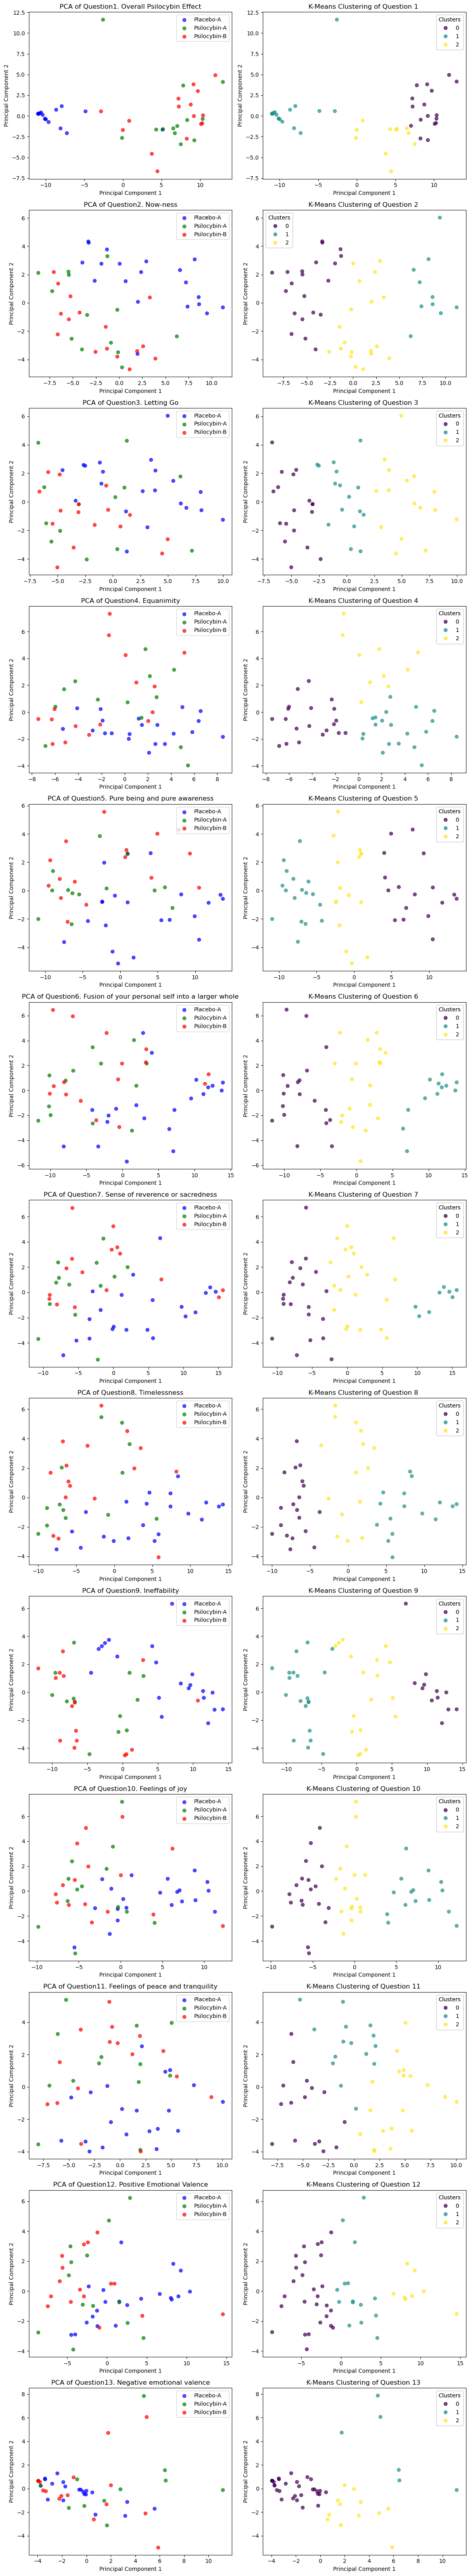

In [13]:
# Define the palette for plotting
# palette = {'Placebo-A': 'blue', 'Psilocybin-B': 'red', 'Psilocybin-A': 'green'}

# Create a figure with subplots
fig, axes = plt.subplots(13, 2, figsize=(12, 65))  # 13 rows, 2 columns

# Loop through each question (feature)
for i in range(13):
    # Extract data for the current question
    data = feature_reshaped[i]

    # Perform PCA on features_interplot
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)

    # Plot for features_interplot (left side)
    for condition in np.unique(condition_reshaped):
        indices = np.where(condition_reshaped == condition)[0]
        axes[i, 0].scatter(pca_result[indices, 0], pca_result[indices, 1],
                           c=palette[condition], label=condition, alpha=0.7)

    axes[i, 0].set_title(f'PCA of Question' + questions[i])
    axes[i, 0].set_xlabel('Principal Component 1')
    axes[i, 0].set_ylabel('Principal Component 2')
    axes[i, 0].legend(loc='upper right')

    # Perform K-Means clustering on PCA result of features_interplot
    n_clusters = 3  # Define the number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(pca_result)

    # Plot K-means clusters (right side)
    scatter = axes[i, 1].scatter(pca_result[:, 0], pca_result[:, 1],
                                 c=clusters, cmap='viridis', alpha=0.7)

    axes[i, 1].set_title(f'K-Means Clustering of Question {i+1} ')
    axes[i, 1].set_xlabel('Principal Component 1')
    axes[i, 1].set_ylabel('Principal Component 2')

    # Add legend for clusters
    legend1 = axes[i, 1].legend(*scatter.legend_elements(), title="Clusters")
    axes[i, 1].add_artist(legend1)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()


## *K=2*

/Users/apple/opt/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/apple/opt/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/apple/opt/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/apple/opt/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

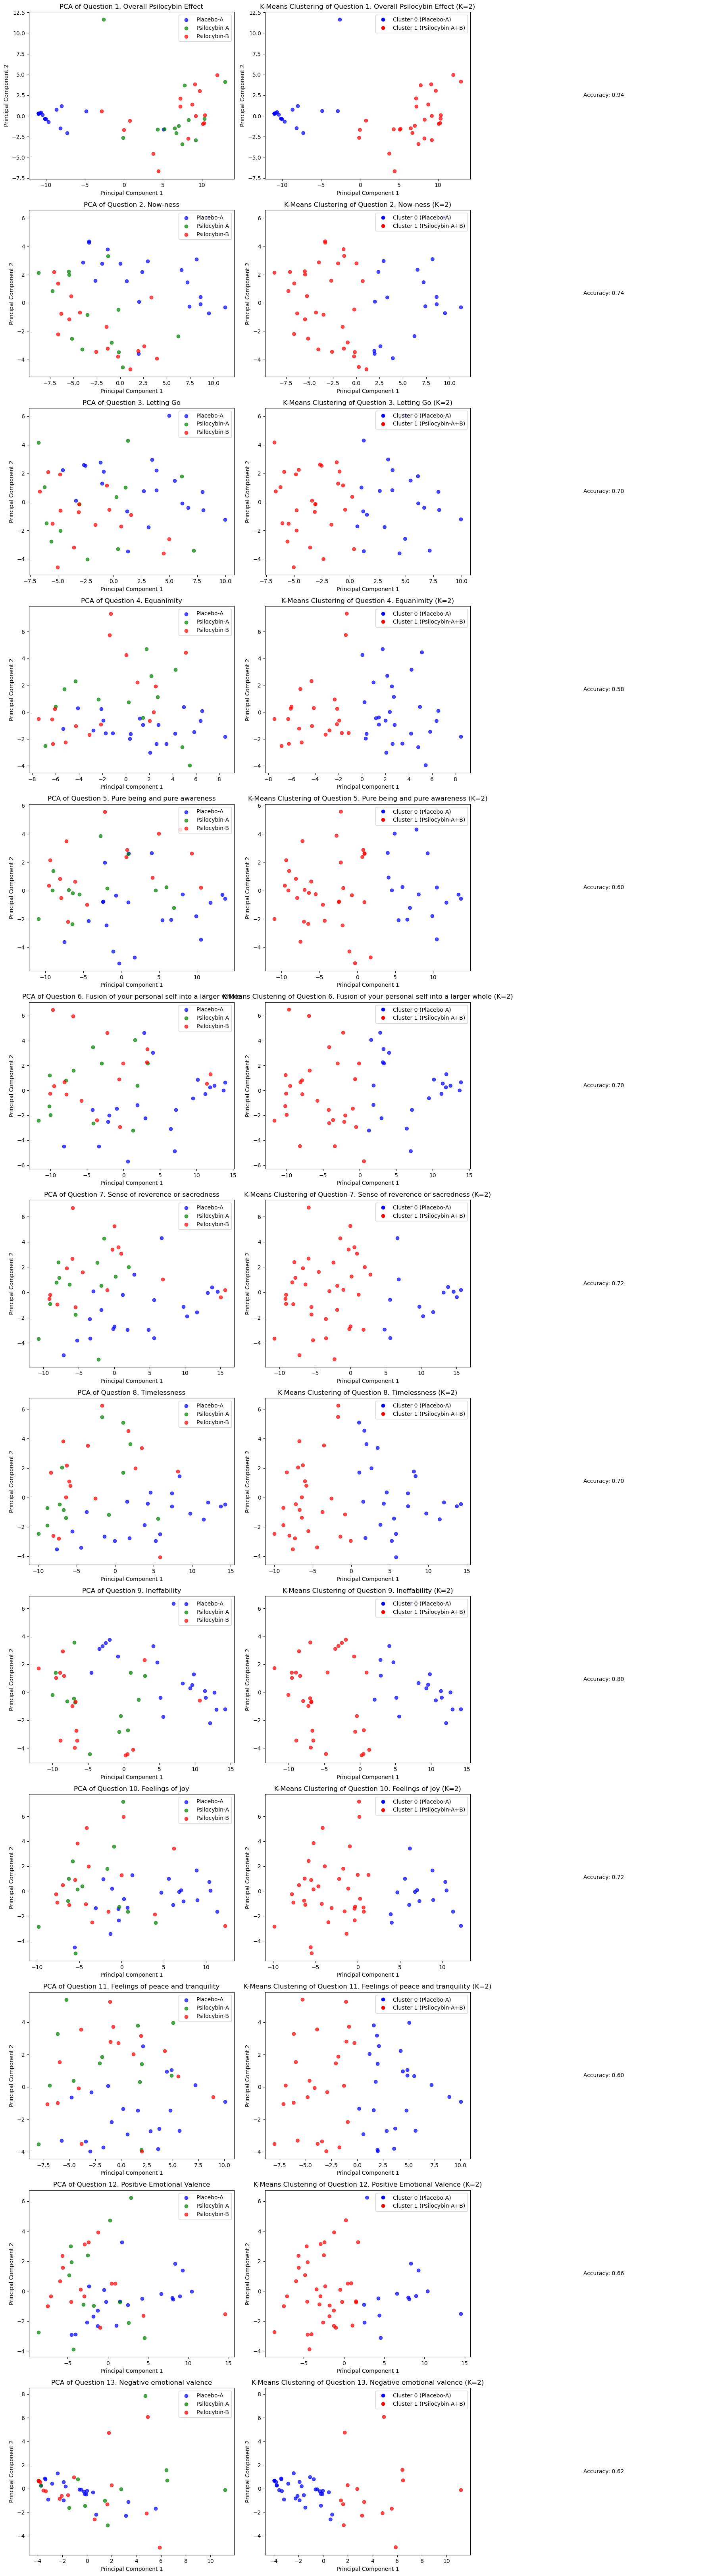

In [14]:
# Perform pca and k-means (k=2) clustering. Plot pca, 'PLA' class in blue, and 'EXP'+'PSIL' in red.  After k-means clustering, make a rotation for each cluster matching each class (class1 PLA, class2: EXP+PSIL) to find the best match that has highest classifying accuracy. Then, plot the k-means clustering, the color should be the same as pca plot, with reference of best match. Then, calculate the accuracy for each question's classification. Make sure the legend of cluster result color matches the color of the dots, blue: cluster0 (PLA), red: cluster1 (EXP+PSIL)

# Define the palette for plotting
#  palette = {'Placebo-A': 'blue', 'Psilocybin-B': 'red', 'Psilocybin-A': 'green'}
accuracies2 = []

# Create a figure with subplots
fig, axes = plt.subplots(13, 3, figsize=(18, 65))  # 13 rows, 3 columns

# Loop through each question (feature)
for i in range(13):
    # Extract data for the current question
    data = feature_reshaped[i]

    # Perform PCA on features_interplot
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)

    # Plot for features_interplot (left side)
    for condition in np.unique(condition_reshaped):
        indices = np.where(condition_reshaped == condition)[0]
        axes[i, 0].scatter(pca_result[indices, 0], pca_result[indices, 1],
                           c=palette[condition], label=condition, alpha=0.7)

    axes[i, 0].set_title(f'PCA of Question {questions[i]}')
    axes[i, 0].set_xlabel('Principal Component 1')
    axes[i, 0].set_ylabel('Principal Component 2')
    axes[i, 0].legend(loc='upper right')


    # Perform K-Means clustering on PCA result of features_interplot
    n_clusters = 2  # Define the number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(pca_result)

    # Find the best match between clusters and classes (PLA, EXP+PSIL)
    true_labels = [1 if c == 'Placebo-A' else 0 for c in condition_reshaped]
    best_accuracy = 0
    best_mapping = None

    for mapping in [(0, 1), (1, 0)]:
        predicted_labels = [mapping[c] for c in clusters]
        accuracy = sum([1 for true, pred in zip(true_labels, predicted_labels) if true == pred]) / len(true_labels)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_mapping = mapping


    # Plot K-means clusters (middle side) with the best mapping
    cluster_colors = ['blue' if best_mapping[c] == 1 else 'red' for c in clusters]  # Adjust mapping
    axes[i, 1].scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_colors, alpha=0.7)


    axes[i, 1].set_title(f'K-Means Clustering of Question {questions[i]} (K=2)')
    axes[i, 1].set_xlabel('Principal Component 1')
    axes[i, 1].set_ylabel('Principal Component 2')

    # Add legend for clusters
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Cluster 0 (Placebo-A)', markerfacecolor='blue', markersize=8),
                       plt.Line2D([0], [0], marker='o', color='w', label='Cluster 1 (Psilocybin-A+B)', markerfacecolor='red', markersize=8)]

    axes[i, 1].legend(handles=legend_elements, loc='upper right')

    # Calculate and plot accuracy
    predicted_labels = [best_mapping[c] for c in clusters]
    accuracy = sum([1 for true, pred in zip(true_labels, predicted_labels) if true == pred]) / len(true_labels)
    accuracies2.append(accuracy)
    axes[i, 2].text(0.5, 0.5, f'Accuracy: {accuracy:.2f}', ha='center', va='center')
    axes[i, 2].axis('off')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

## *k=3*

/Users/apple/opt/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/apple/opt/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/apple/opt/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/apple/opt/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

Accuracy for Question 1 (PLA classification): 0.94
Accuracy for Question 2 (PLA classification): 0.74
Accuracy for Question 3 (PLA classification): 0.74
Accuracy for Question 4 (PLA classification): 0.74
Accuracy for Question 5 (PLA classification): 0.66
Accuracy for Question 6 (PLA classification): 0.74
Accuracy for Question 7 (PLA classification): 0.66
Accuracy for Question 8 (PLA classification): 0.78
Accuracy for Question 9 (PLA classification): 0.78
Accuracy for Question 10 (PLA classification): 0.72
Accuracy for Question 11 (PLA classification): 0.64
Accuracy for Question 12 (PLA classification): 0.70
Accuracy for Question 13 (PLA classification): 0.62


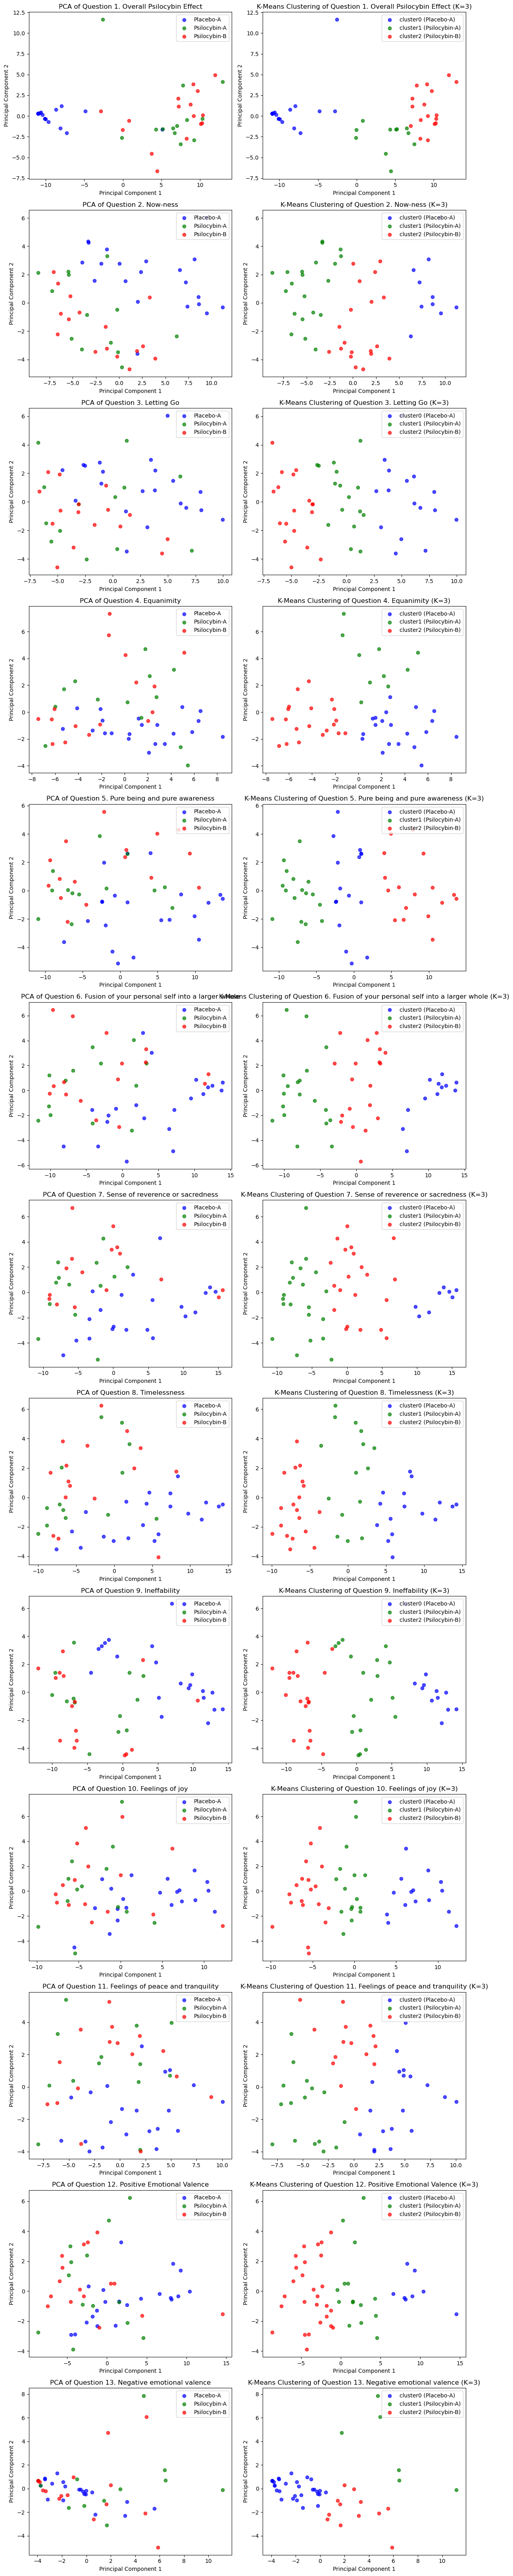

In [15]:
# Perform pca and k-means (k=3) clustering. Plot pca, 'PLA' class in blue, and 'EXP'+'PSIL' in red.  After k-means clustering, make a rotation for each cluster matching each class (class1 PLA, class2: EXP, class3: PSIL) to find the best match that has highest classifying accuracy. Then, plot the k-means clustering, the color should be the same as pca plot, with reference of best match. Then, calculate the accuracy for each question's classification (the cluster matches PLA, and combine the other two clusters to match EXP+PSIL)
#{'Placebo-A': 'blue', 'Psilocybin-B': 'red', 'Psilocybin-A': 'green'}

# Create a figure with subplots
fig, axes = plt.subplots(13, 2, figsize=(12, 65))  # 13 rows, 2 columns
accuracies3 = []
# Loop through each question (feature)
for i in range(13):
    # Extract data for the current question
    data = feature_reshaped[i]

    # Perform PCA on features
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)

    # Plot for features (left side)
    for condition in np.unique(condition_reshaped):
        indices = np.where(condition_reshaped == condition)[0]
        axes[i, 0].scatter(pca_result[indices, 0], pca_result[indices, 1],
                           c=palette[condition], label=condition, alpha=0.7)

    axes[i, 0].set_title(f'PCA of Question {questions[i]}')
    axes[i, 0].set_xlabel('Principal Component 1')
    axes[i, 0].set_ylabel('Principal Component 2')
    axes[i, 0].legend(loc='upper right')

    # Perform K-Means clustering on PCA result of features_interplot
    n_clusters = 3  # Define the number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(pca_result)

    # Find the best match for cluster labels to conditions (PLA, EXP, PSIL)
    best_accuracy = 0
    best_mapping = None
    for mapping in [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]:
        predicted_labels = np.where(clusters == mapping[0], 'Placebo-A',
                                    np.where(clusters == mapping[1], 'Psilocybin-B', 'Psilocybin-A'))
        accuracy = accuracy_score(condition_reshaped, predicted_labels)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_mapping = mapping

    # Plot K-means clusters (right side) with best mapping
    if best_mapping:
        predicted_labels = np.where(clusters == best_mapping[0], 'Placebo-A',
                                    np.where(clusters == best_mapping[1], 'Psilocybin-B', 'Psilocybin-A'))
        for label in np.unique(predicted_labels):
            indices = np.where(predicted_labels == label)[0]
            axes[i, 1].scatter(pca_result[indices, 0], pca_result[indices, 1],
                               c=palette[label], label=label, alpha=0.7)

    axes[i, 1].set_title(f'K-Means Clustering of Question {questions[i]} (K=3)')
    axes[i, 1].set_xlabel('Principal Component 1')
    axes[i, 1].set_ylabel('Principal Component 2')


    # Calculate accuracy for PLA classification (cluster matches PLA, combine other two clusters to match EXP+PSIL)
    if best_mapping:
        predicted_labels = np.where(clusters == best_mapping[0], 'Placebo-A', 'Psilocybin-A+B')
        accuracy = accuracy_score(np.where(condition_reshaped == 'Placebo-A', 'Placebo-A', 'Psilocybin-A+B'), predicted_labels)
        print(f"Accuracy for Question {i+1} (PLA classification): {accuracy:.2f}")
    accuracies3.append(accuracy)
    # axes[i, 2].text(0.5, 0.5, f'Accuracy: {accuracy:.2f}', ha='center', va='center')
    # axes[i, 2].axis('off')

    # Add legend for clusters
    handles, labels = axes[i, 1].get_legend_handles_labels()
    unique_labels = ['cluster0 (Placebo-A)','cluster1 (Psilocybin-A)', 'cluster2 (Psilocybin-B)']
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            #unique_labels.append(label)
            unique_handles.append(handle)
    axes[i, 1].legend(unique_handles, unique_labels, loc='upper right')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

In [16]:
questions

['1. Overall Psilocybin Effect',
 '2. Now-ness',
 '3. Letting Go',
 '4. Equanimity',
 '5. Pure being and pure awareness',
 '6. Fusion of your personal self into a larger whole',
 '7. Sense of reverence or sacredness',
 '8. Timelessness',
 '9. Ineffability',
 '10. Feelings of joy',
 '11. Feelings of peace and tranquility',
 '12. Positive Emotional Valence',
 '13. Negative emotional valence']

In [17]:
# prompt: count number of pla in condition_reshaped

pla_count = np.sum(condition_reshaped == 'PLA')
print(f"Number of 'PLA' in condition_reshaped: {pla_count}")

Number of 'PLA' in condition_reshaped: 0


## *Plot accuracy*

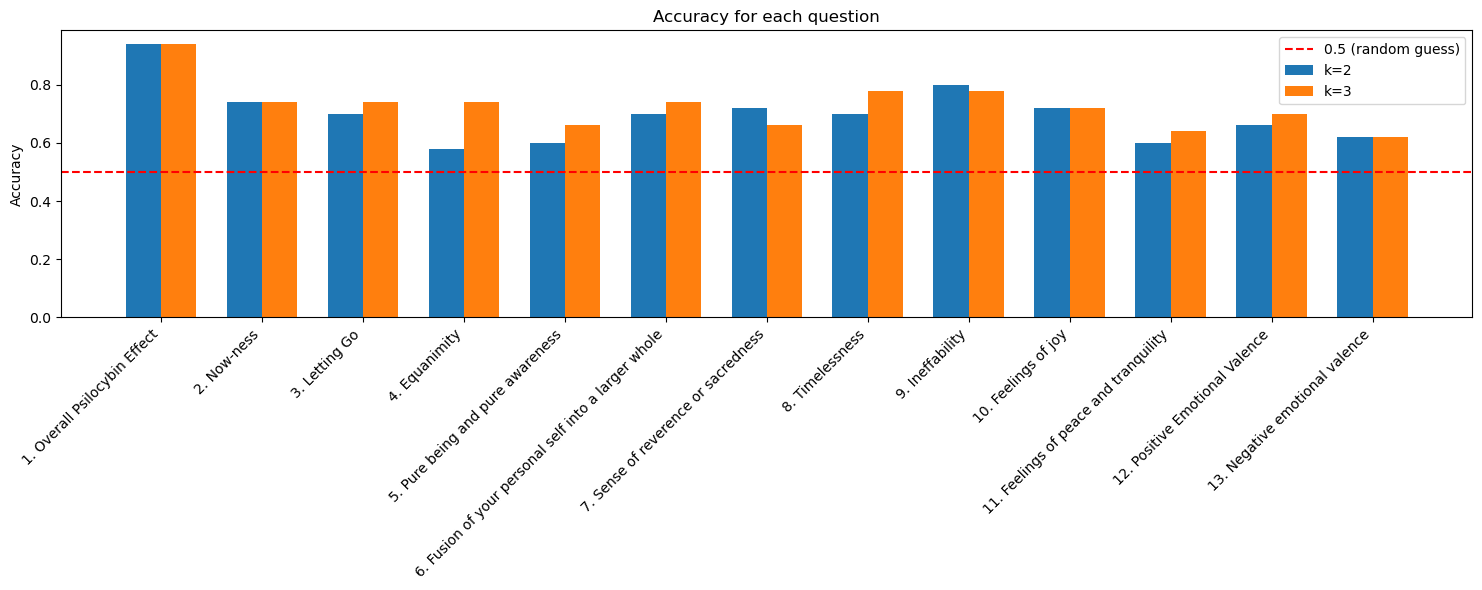

In [18]:
# Plot the accuracies for each question contained in list question. accuracy scores stored in accuracies2 and accuracies3. plot them in bar graphs. Legend set score in accuracies2 as k=2, accuracies3 as k=3, draw a threshold line at 0.58

x = np.arange(len(questions))  # The label locations
width = 0.35  # The width of the bars

fig, ax = plt.subplots(figsize=(15, 6))  # Adjust figure size as needed
rects1 = ax.bar(x - width / 2, accuracies2, width, label='k=2')
rects2 = ax.bar(x + width / 2, accuracies3, width, label='k=3')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for each question')
ax.set_xticks(x, questions, rotation=45, ha='right')


# Add a horizontal line at 0.58
ax.axhline(y=0.50, color='red', linestyle='--', label='0.5 (random guess)')

ax.legend()

# Adjust layout and show the figure
fig.tight_layout()
plt.show()

# Varimax Rotation

In [21]:
pca_result.shape

(50, 2)

In [19]:
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd

def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in list(range(q)):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R)

rotated_components = varimax(pca_result)

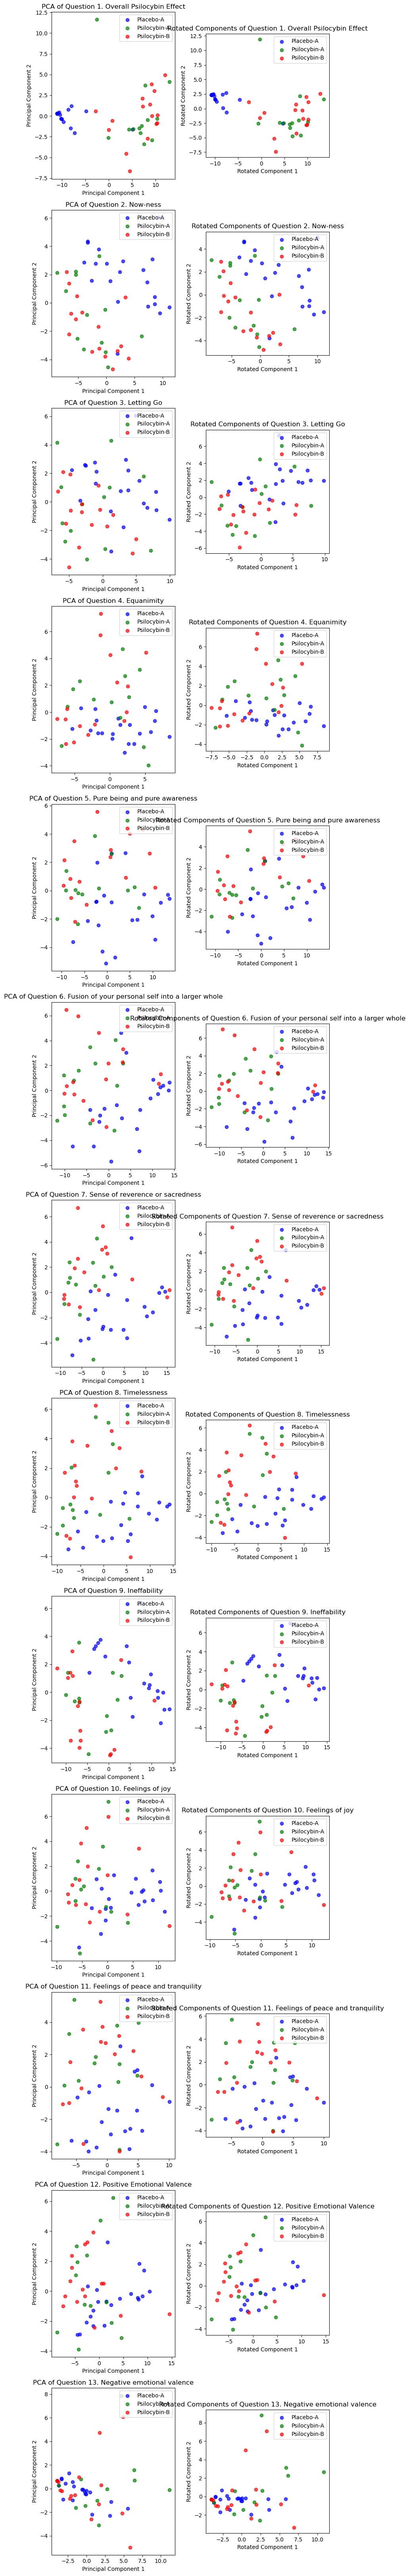

In [24]:
# visualize rotated_components

# Create a figure with subplots
fig, axes = plt.subplots(13, 2, figsize=(8, 65))  # 13 rows, 1 column

# Loop through each question (feature)
for i in range(13):
    # Extract data for the current question
    data = feature_reshaped[i]

    # Perform PCA on features
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)


    data = varimax(pca_result)
    ###############################
    # Plot for features (left side)
    for condition in np.unique(condition_reshaped):
        indices = np.where(condition_reshaped == condition)[0]
        axes[i, 0].scatter(pca_result[indices, 0], pca_result[indices, 1],
                           c=palette[condition], label=condition, alpha=0.7)

    axes[i, 0].set_title(f'PCA of Question {questions[i]}')
    axes[i, 0].set_xlabel('Principal Component 1')
    axes[i, 0].set_ylabel('Principal Component 2')
    axes[i, 0].legend(loc='upper right')

    ##############################
    # Plot for rotated components
    for condition in np.unique(condition_reshaped):
        indices = np.where(condition_reshaped == condition)[0]
        axes[i,1].scatter(data[indices, 0], data[indices, 1],
                           c=palette[condition], label=condition, alpha=0.7)

    axes[i,1].set_title(f'Rotated Components of Question {questions[i]}')
    axes[i,1].set_xlabel('Rotated Component 1')
    axes[i,1].set_ylabel('Rotated Component 2')
    axes[i,1].set_box_aspect(1)

    # Remove duplicate labels from legend
    handles, labels = axes[i,1].get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    axes[i,1].legend(unique_handles, unique_labels, loc='upper right')



# Adjust layout and show the figure
plt.tight_layout()
plt.show()